In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, train_test_split

from keras import backend as K
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Lambda
from keras.layers import AveragePooling2D, Input, Activation
from keras.losses import categorical_crossentropy
from keras.layers.merge import Add
from keras.optimizers import Adam, Adadelta
from keras.preprocessing.image import ImageDataGenerator

SEED = 666
np.random.seed(SEED)

Using TensorFlow backend.


In [3]:
img_rows, img_cols = 28, 28

(x_train, y_train), (x_test, _) = fashion_mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train     = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test      = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
    
    chan_axis = 1
    row_axis  = 2
    col_axis  = 3
else:
    x_train     = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test      = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
    row_axis  = 1
    col_axis  = 2
    chan_axis = 3
    
x_train  = x_train.astype('float32')
x_test   = x_test.astype('float32')
x_train /= 255
x_test  /= 255

In [4]:
num_classes = 10

y_train = to_categorical(y_train, num_classes)

In [5]:
print(x_train.shape)

(60000, 28, 28, 1)


## Data augmentation

Function for showing particular image

In [6]:
def print_img(x_tab, y_tab, num):
    plt.title('Label is {label}'.format(label=y_tab[num]))
    plt.imshow(x_tab[num].reshape((img_cols, img_rows)), cmap='gray')
    plt.show()

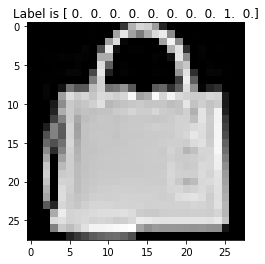

In [6]:
example = np.random.randint(0, len(x_train))

print_img(x_train, y_train, example)

Flipping images along y axis (later I've chosen to instead use ImageDataGenerator from Keras):

In [59]:
x_train_flip = np.copy(x_train)
y_train_flip = np.copy(y_train)

for i in range(len(x_train_flip)):
    x_train_flip[i] = np.flip(x_train_flip[i], 1)

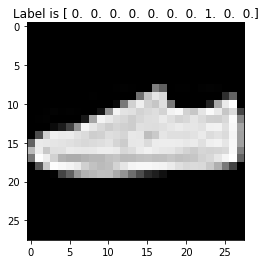

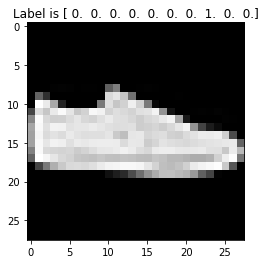

In [60]:
example = np.random.randint(0, len(x_train))

print_img(x_train, y_train, example)
print_img(x_train_flip, y_train_flip, example)

In [61]:
x_train = np.concatenate((x_train, x_train_flip), axis=0)
y_train = np.concatenate((y_train, y_train_flip), axis=0)

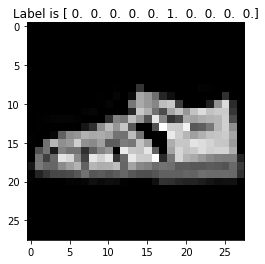

In [62]:
example = np.random.randint(0, len(x_train))

print_img(x_train, y_train, example)

## Helper functions

In [7]:
def train_evaluate(model, x_tab_tr, y_tab_tr, x_tab_te, y_tab_te, epochs, batch):
    model.fit(x_tab_tr, y_tab_tr, epochs=epochs, batch_size=batch, validation_data=(x_tab_te, y_tab_te))#, verbose=0)

In [8]:
def k_fold(model_func, n_folds, x_tab, y_tab, epochs, batch):
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
    i = 0

    for train, test in skf.split(y_tab, np.argmax(y_tab, axis=1)):
            print("Running Fold %d / %d" % (i+1, n_folds))
            i += 1
            cnn = None
            cnn = model_func()
            train_evaluate(cnn, x_tab[train], y_tab[train], x_tab[test], y_tab[test], epochs, batch)
            cnn.optimizer.lr = 0.0001
            train_evaluate(cnn, x_tab[train], y_tab[train], x_tab[test], y_tab[test], epochs, batch)

In [9]:
def input_normalization(x):
    mean = x_train.mean().astype(np.float32)
    std  = x_train.std().astype(np.float32)
    return (x - mean) / std

## Basic CNN

In [51]:
def basic_cnn():
    model = Sequential()
    model.add(Lambda(input_normalization, input_shape=input_shape))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy'])
    
    return model

In [52]:
k_fold(basic_cnn, 5, x_train, y_train, 10, 128)

ValueError: axis(=1) out of bounds

## VGG-based model

In [15]:
def vgg_clone():
    model = Sequential()
    
    model.add(Lambda(input_normalization, input_shape=input_shape))
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation='softmax', name='final_dense'))
    
    model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy'])
    
    return model

In [117]:
k_fold(vgg_clone, 5, x_train, y_train, 10, 512)

Running Fold 1 / 5
Train on 96000 samples, validate on 24000 samples
Epoch 1/10
96000/96000 [==============================] - 24s 245us/step - loss: 0.7027 - acc: 0.7538 - val_loss: 2.2540 - val_acc: 0.2858
Epoch 2/10
96000/96000 [==============================] - 21s 221us/step - loss: 0.3354 - acc: 0.8793 - val_loss: 0.6996 - val_acc: 0.7655
Epoch 3/10
96000/96000 [==============================] - 21s 221us/step - loss: 0.2676 - acc: 0.9023 - val_loss: 0.3623 - val_acc: 0.8700
Epoch 4/10
96000/96000 [==============================] - 21s 222us/step - loss: 0.2342 - acc: 0.9151 - val_loss: 0.3788 - val_acc: 0.8739
Epoch 5/10
96000/96000 [==============================] - 21s 222us/step - loss: 0.2071 - acc: 0.9245 - val_loss: 0.3029 - val_acc: 0.8842
Epoch 6/10
96000/96000 [==============================] - 21s 222us/step - loss: 0.1867 - acc: 0.9311 - val_loss: 0.3245 - val_acc: 0.8958
Epoch 7/10
96000/96000 [==============================] - 21s 221us/step - loss: 0.1700 - acc: 0.

KeyboardInterrupt: 

### VGG single model - submission

In [16]:
model = vgg_clone()
model.fit(x_train, y_train, epochs=10, batch_size=512)
model.optimizer.lr = 0.0001
model.fit(x_train, y_train, epochs=5, batch_size=512)

Epoch 1/10
120000/120000 [==============================] - 27s 222us/step - loss: 0.5898 - acc: 0.7917
Epoch 2/10
120000/120000 [==============================] - 25s 205us/step - loss: 0.2948 - acc: 0.8932
Epoch 3/10
120000/120000 [==============================] - 24s 204us/step - loss: 0.2391 - acc: 0.9131
Epoch 4/10
120000/120000 [==============================] - 24s 204us/step - loss: 0.2099 - acc: 0.9251
Epoch 5/10
120000/120000 [==============================] - 24s 204us/step - loss: 0.1880 - acc: 0.9321
Epoch 6/10
120000/120000 [==============================] - 24s 204us/step - loss: 0.1700 - acc: 0.9377
Epoch 7/10
120000/120000 [==============================] - 25s 205us/step - loss: 0.1568 - acc: 0.9425
Epoch 8/10
120000/120000 [==============================] - 25s 210us/step - loss: 0.1445 - acc: 0.9469
Epoch 9/10
120000/120000 [==============================] - 25s 204us/step - loss: 0.1351 - acc: 0.9506
Epoch 10/10
120000/120000 [==============================] - 25s

In [17]:
result = model.predict(x_test)
submission = np.argmax(result, axis=1)
print(submission)

[9 2 1 ..., 8 1 5]


In [18]:
with open('vgg-submission.csv', 'w') as f:
    f.write('Id,Class\n')
    for i, c in enumerate(submission):
        f.write('{},{}\n'.format(i, c))

## WideResNet

Based on https://arxiv.org/pdf/1605.07146.pdf

In [18]:
def wrn_clone(n=4, k=2, D=0.0):
    
    def merge(x, y):
        x_shape = K.int_shape(x)
        y_shape = K.int_shape(y)
        stride_w = int(round(x_shape[row_axis] / y_shape[row_axis]))
        stride_h = int(round(x_shape[col_axis] / y_shape[col_axis]))
        
        if x_shape[chan_axis] != y_shape[chan_axis]:
            x = Conv2D(filters=y_shape[chan_axis], kernel_size=(1, 1),
                             strides=(stride_w, stride_h), padding="valid")(x)
        
        output = Add()([x, y])
        
        return output
        
    
    # Conv1 [3x3, 16]
    def conv1(x):
        output = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(x)
        output = BatchNormalization(axis=chan_axis)(output)
        output = Activation('relu')(output)
        
        return output
    
    # Conv2 [3 x 3, 16 x k] x 2
    def conv2(x, k, d=0.0):
        skip = x
        
        output = BatchNormalization(axis=chan_axis)(x)
        output = Activation('relu')(output)
        output = Conv2D(16 * k, kernel_size=(3, 3), activation='relu', padding='same')(output)
        
        output = Dropout(d)(output)
        
        output = BatchNormalization()(output)
        output = Activation('relu')(output)
        output = Conv2D(16 * k, kernel_size=(3, 3), activation='relu', padding='same')(output)
        
        output = merge(skip, output)
        
        return output
    
    # Conv3 [3 x 3, 32 x k] x 2
    def conv3(x, k, d=0.0):
        skip = x
        
        output = BatchNormalization(axis=chan_axis)(x)
        output = Activation('relu')(output)
        output = Conv2D(32 * k, kernel_size=(3, 3), activation='relu', padding='same')(output)
        
        output = Dropout(d)(output)
        
        output = BatchNormalization(axis=chan_axis)(output)
        output = Activation('relu')(output)
        output = Conv2D(32 * k, kernel_size=(3, 3), activation='relu', padding='same')(output)
        
        output = merge(skip, output)
        
        return output
    
    # Conv4 [3 x 3, 64 x k] x 2
    def conv4(x, k, d=0.0):
        skip = x
        
        output = BatchNormalization(axis=chan_axis)(x)
        output = Activation('relu')(output)
        output = Conv2D(64 * k, kernel_size=(3, 3), activation='relu', padding='same')(output)
        
        output = Dropout(d)(output)
        
        output = BatchNormalization(axis=chan_axis)(output)
        output = Activation('relu')(output)
        output = Conv2D(64 * k, kernel_size=(3, 3), activation='relu', padding='same')(output)
        
        output = merge(skip, output)
        
        return output 
    
    def final_block(x):
        output = BatchNormalization(axis=chan_axis)(x)
        output = Activation('relu')(output)
        output = AveragePooling2D()(output)
        output = Flatten()(output)
        output = Dense(num_classes, activation='softmax')(output)
        
        return output
    
    x = Input(shape=input_shape)
    output = Lambda(input_normalization)(x)
    output = conv1(output)
    
    for i in range(n):
        output = conv2(output, k, D)
    
    for i in range(n):
        output = conv3(output, k, D)
    
    for i in range(n):
        output = conv4(output, k, D)
        
    output = final_block(output)
    
    model = Model(x, output)
    model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
    
    return model

In [19]:
k_fold(lambda: wrn_clone(k=2), 5, x_train, y_train, 10, 128)

Running Fold 1 / 5
Train on 48000 samples, validate on 12000 samples
Epoch 1/10
 2560/48000 [>.............................] - ETA: 1:47 - loss: 1.3926 - acc: 0.6270

KeyboardInterrupt: 

#### Training

I assumed that with both random data augmentation & dropout the network shouldn't overfit (badly).

In [12]:
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

datagen.fit(x_train)

In [16]:
x_t, x_val, y_t, y_val = train_test_split(x_train, y_train, test_size=0.16, random_state=666, stratify=y_train)

In [13]:
model = None
model = wrn_clone(k=2, D=0.2)

In [17]:
model.fit_generator(datagen.flow(x_t, y_t, batch_size=256),
                    steps_per_epoch=len(x_train) / 256, epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
235/234 [==============================] - 103s 437ms/step - loss: 0.6749 - acc: 0.7866 - val_loss: 0.5993 - val_acc: 0.8183
Epoch 2/10
235/234 [==============================] - 99s 422ms/step - loss: 0.3691 - acc: 0.8681 - val_loss: 0.3076 - val_acc: 0.8966
Epoch 3/10
235/234 [==============================] - 99s 423ms/step - loss: 0.3304 - acc: 0.8827 - val_loss: 0.6653 - val_acc: 0.7973
Epoch 4/10
235/234 [==============================] - 100s 425ms/step - loss: 0.3056 - acc: 0.8915 - val_loss: 0.2552 - val_acc: 0.9108
Epoch 5/10
235/234 [==============================] - 100s 426ms/step - loss: 0.2682 - acc: 0.9030 - val_loss: 0.2650 - val_acc: 0.9066
Epoch 6/10
235/234 [==============================] - 100s 428ms/step - loss: 0.2627 - acc: 0.9045 - val_loss: 0.2364 - val_acc: 0.9161
Epoch 7/10
235/234 [==============================] - 101s 428ms/step - loss: 0.2403 - acc: 0.9128 - val_loss: 0.2141 - val_acc: 0.9245
Epoch 8/10
235/234 [==============================

#### Training for submission

In [19]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=256),
                    steps_per_epoch=len(x_train) / 256, epochs=10)

Epoch 1/10
235/234 [==============================] - 95s 402ms/step - loss: 0.2183 - acc: 0.9240
Epoch 2/10
235/234 [==============================] - 94s 399ms/step - loss: 0.2004 - acc: 0.9273
Epoch 3/10
235/234 [==============================] - 98s 416ms/step - loss: 0.1914 - acc: 0.9314
Epoch 4/10
235/234 [==============================] - 96s 410ms/step - loss: 0.1850 - acc: 0.9327
Epoch 5/10
235/234 [==============================] - 96s 410ms/step - loss: 0.1846 - acc: 0.9341
Epoch 6/10
235/234 [==============================] - 97s 413ms/step - loss: 0.1799 - acc: 0.9356
Epoch 7/10
235/234 [==============================] - 95s 405ms/step - loss: 0.1762 - acc: 0.9365
Epoch 8/10
235/234 [==============================] - 95s 403ms/step - loss: 0.1721 - acc: 0.9380
Epoch 9/10
235/234 [==============================] - 95s 404ms/step - loss: 0.3183 - acc: 0.9103
Epoch 10/10
235/234 [==============================] - 95s 405ms/step - loss: 0.2099 - acc: 0.9262


In [24]:
model.optimizer.lr = 0.0005
model.fit_generator(datagen.flow(x_train, y_train, batch_size=256),
                    steps_per_epoch=len(x_train) / 256, epochs=2)

Epoch 1/2
235/234 [==============================] - 95s 406ms/step - loss: 0.1279 - acc: 0.9540
Epoch 2/2
235/234 [==============================] - 95s 402ms/step - loss: 0.1275 - acc: 0.9546


In [25]:
model.optimizer.lr = 0.0001
model.fit_generator(datagen.flow(x_train, y_train, batch_size=256),
                    steps_per_epoch=len(x_train) / 256, epochs=5)

Epoch 1/5
235/234 [==============================] - 96s 410ms/step - loss: 0.1205 - acc: 0.9563
Epoch 2/5
235/234 [==============================] - 94s 400ms/step - loss: 0.1196 - acc: 0.9568
Epoch 3/5
235/234 [==============================] - 94s 400ms/step - loss: 0.1205 - acc: 0.9566
Epoch 4/5
235/234 [==============================] - 94s 400ms/step - loss: 0.1129 - acc: 0.9589
Epoch 5/5
235/234 [==============================] - 94s 401ms/step - loss: 0.1158 - acc: 0.9583


In [26]:
model.optimizer.lr = 0.00005
model.fit_generator(datagen.flow(x_train, y_train, batch_size=256),
                    steps_per_epoch=len(x_train) / 256, epochs=5)

Epoch 1/5
235/234 [==============================] - 94s 399ms/step - loss: 0.1122 - acc: 0.9600
Epoch 2/5
235/234 [==============================] - 94s 399ms/step - loss: 0.1083 - acc: 0.9608
Epoch 3/5
235/234 [==============================] - 94s 400ms/step - loss: 0.1172 - acc: 0.9584
Epoch 4/5
235/234 [==============================] - 94s 402ms/step - loss: 0.1130 - acc: 0.9587
Epoch 5/5
235/234 [==============================] - 94s 401ms/step - loss: 0.1087 - acc: 0.9608


In [16]:
model.optimizer.lr = 0.00001
model.fit_generator(datagen.flow(x_train, y_train, batch_size=256),
                    steps_per_epoch=len(x_train) / 256, epochs=5)

Epoch 1/5
235/234 [==============================] - 100s 424ms/step - loss: 0.0826 - acc: 0.9708
Epoch 2/5
235/234 [==============================] - 98s 418ms/step - loss: 0.0766 - acc: 0.9718
Epoch 3/5
235/234 [==============================] - 99s 422ms/step - loss: 0.0735 - acc: 0.9732
Epoch 4/5
235/234 [==============================] - 101s 431ms/step - loss: 0.0765 - acc: 0.9717
Epoch 5/5
235/234 [==============================] - 101s 428ms/step - loss: 0.0733 - acc: 0.9736


#### Submission

In [17]:
result = model.predict(x_test)
submission = np.argmax(result, axis=1)
print(submission)
with open('wrn-submission8.csv', 'w') as f:
    f.write('Id,Class\n')
    for i, c in enumerate(submission):
        f.write('{},{}\n'.format(i, c))

[9 2 1 ..., 8 1 5]
